<a href="https://colab.research.google.com/github/ridazaneb/sentimentanalysis/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install requests


In [8]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Your NewsAPI key
api_key = 'your_api_key'

# Define the date range (last 30 days)
end_date = datetime.now().date()
start_date = end_date - timedelta(days=30)

# Query parameters
query = 'Election2024'  # Replace with your topic of interest
url = (
    f'https://newsapi.org/v2/everything?q={query}&language=en'
    f'&from={start_date}&to={end_date}&pageSize=100&apiKey={api_key}'
)

# Fetch the articles
response = requests.get(url)
data = response.json()

# Check if the request was successful
if data['status'] == 'ok':
    articles = data['articles']
    df = pd.DataFrame([(article['title'], article['description'], article['publishedAt']) for article in articles],
                      columns=['Title', 'Description', 'PublishedAt'])
else:
    print("Error:", data['message'])

# Display DataFrame
print(df.head())


                                               Title  \
0  Does World Liberty Financial Count as Trump 'L...   
1  Does World Liberty Financial Count as Trump 'L...   
2  Harris Campaign Pulls Millions in Ad Spending ...   
3  Harris Removing $2 Million Worth of Ads From N...   
4  ‘Pathetic’: Media expert shreds ’60 Minutes’ r...   

                                         Description           PublishedAt  
0  Plus, a look at how PoliFi tokens are doing co...  2024-10-14T15:45:37Z  
1  Plus, a look at how PoliFi tokens are doing co...  2024-10-14T16:03:49Z  
2  Vice President Kamala Harris’s campaign has pu...  2024-10-29T21:28:42Z  
3  Harris and Trump will spend the day in North C...  2024-10-29T18:49:23Z  
4  Howard Kurtz, the former Washington Post media...  2024-10-21T21:10:41Z  


In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Combine title and description for sentiment analysis
df['Text'] = df['Title'] + " " + df['Description']

# Text preprocessing function
def preprocess(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)  # Remove special characters
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.lower() not in stop_words]
    return ' '.join(words)

df['Cleaned_Text'] = df['Text'].apply(preprocess)
print(df['Cleaned_Text'].head())


0    world liberty financial count trump launching ...
1    world liberty financial count trump launching ...
2    harris campaign pulls millions ad spending nor...
3    harris removing 2 million worth ads north caro...
4    pathetic media expert shreds 60 minutes respon...
Name: Cleaned_Text, dtype: object


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Apply VADER to get sentiment scores
df['Sentiment'] = df['Cleaned_Text'].apply(lambda x: 'positive' if sid.polarity_scores(x)['compound'] > 0 else ('negative' if sid.polarity_scores(x)['compound'] < 0 else 'neutral'))

print(df[['Cleaned_Text', 'Sentiment']].head())


                                        Cleaned_Text Sentiment
0  world liberty financial count trump launching ...  positive
1  world liberty financial count trump launching ...  positive
2  harris campaign pulls millions ad spending nor...  negative
3  harris removing 2 million worth ads north caro...  positive
4  pathetic media expert shreds 60 minutes respon...  negative


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


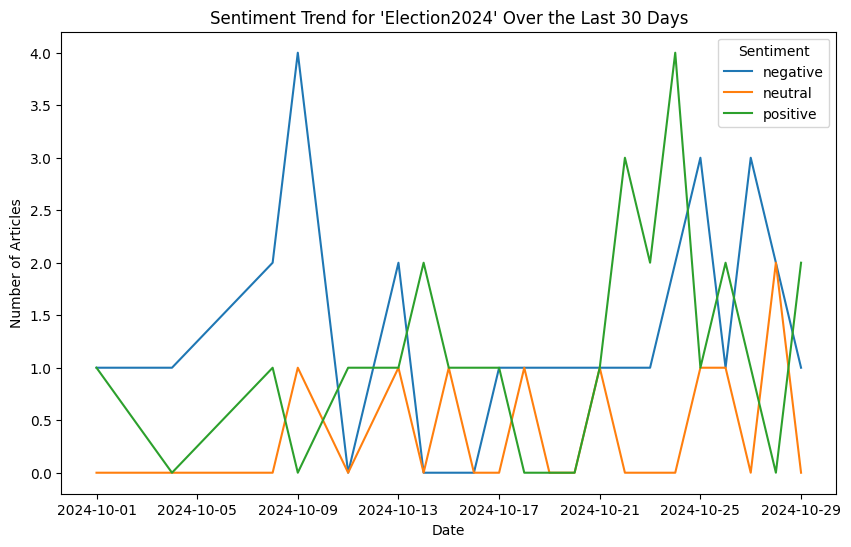

In [11]:
import matplotlib.pyplot as plt

# Convert PublishedAt to datetime for time series analysis
df['PublishedAt'] = pd.to_datetime(df['PublishedAt']).dt.date

# Aggregate sentiment counts by date
sentiment_over_time = df.groupby(['PublishedAt', 'Sentiment']).size().unstack().fillna(0)

# Plot sentiment trends over time
sentiment_over_time.plot(kind='line', figsize=(10, 6))
plt.title(f"Sentiment Trend for '{query}' Over the Last 30 Days")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.show()


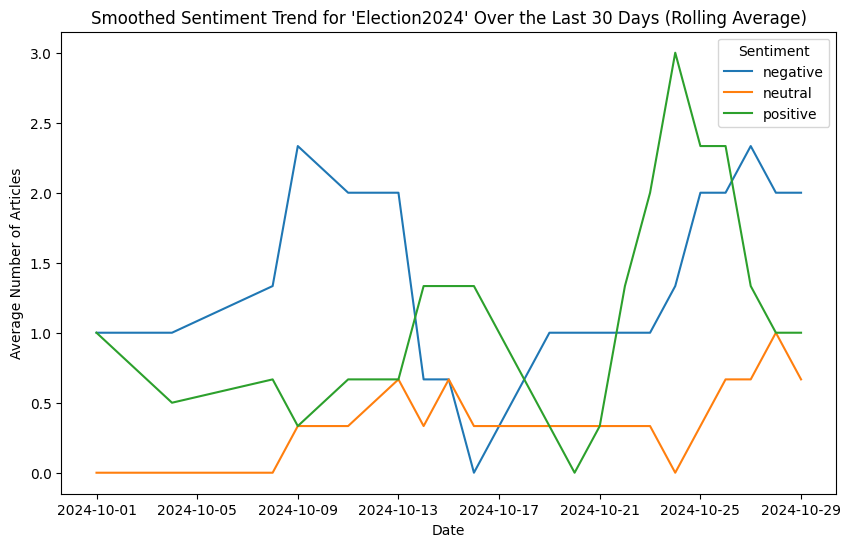

In [12]:
# Set the rolling window (e.g., 3 days)
rolling_window = 3

# Apply a rolling average to smooth out daily fluctuations
smoothed_sentiment = sentiment_over_time.rolling(window=rolling_window, min_periods=1).mean()

# Plot the smoothed sentiment trends
smoothed_sentiment.plot(kind='line', figsize=(10, 6))
plt.title(f"Smoothed Sentiment Trend for '{query}' Over the Last 30 Days (Rolling Average)")
plt.xlabel("Date")
plt.ylabel("Average Number of Articles")
plt.legend(title="Sentiment")
plt.show()


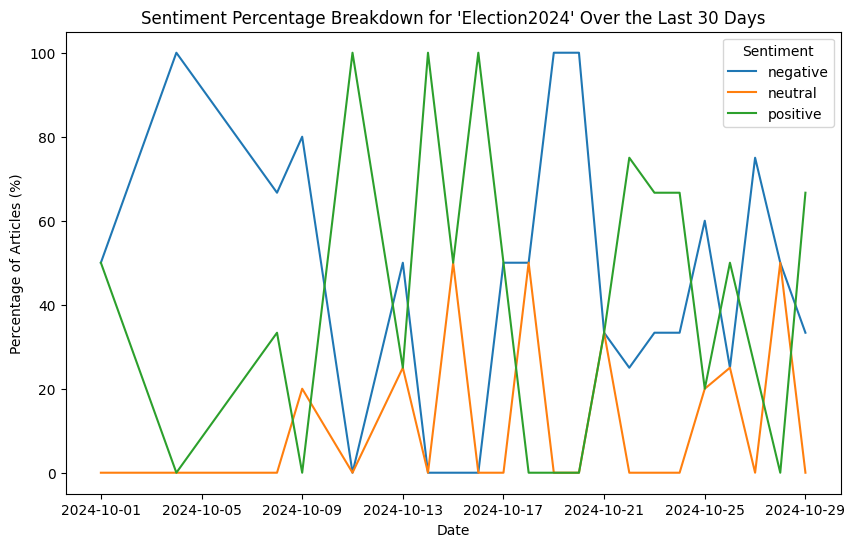

In [13]:
# Calculate the daily percentage of each sentiment type
sentiment_percentage = sentiment_over_time.div(sentiment_over_time.sum(axis=1), axis=0) * 100

# Plot the sentiment percentage breakdown
sentiment_percentage.plot(kind='line', figsize=(10, 6))
plt.title(f"Sentiment Percentage Breakdown for '{query}' Over the Last 30 Days")
plt.xlabel("Date")
plt.ylabel("Percentage of Articles (%)")
plt.legend(title="Sentiment")
plt.show()


In [14]:
!pip install textblob


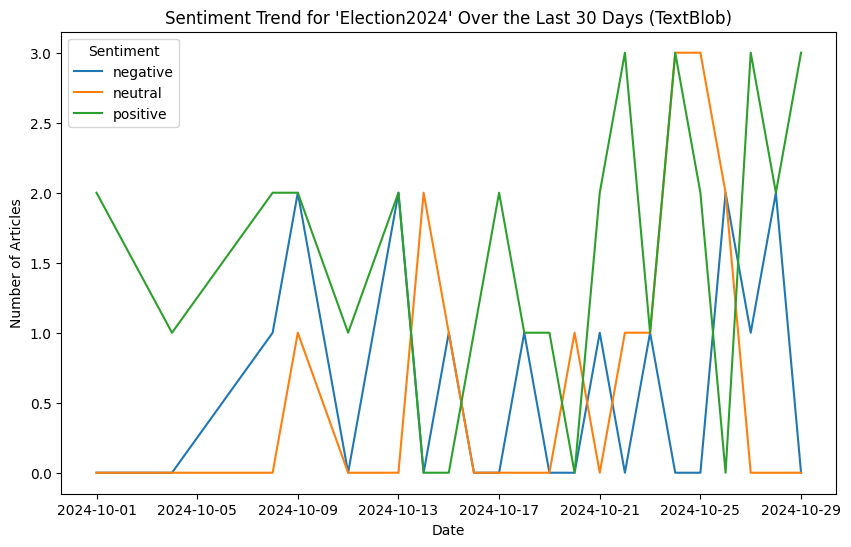

In [15]:
from textblob import TextBlob

# Function to classify sentiment with TextBlob
def textblob_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply TextBlob sentiment analysis
df['TextBlob_Sentiment'] = df['Cleaned_Text'].apply(textblob_sentiment)

# Group by date and sentiment to get daily counts for TextBlob sentiment
sentiment_over_time_textblob = df.groupby(['PublishedAt', 'TextBlob_Sentiment']).size().unstack().fillna(0)

# Plot the sentiment trend with TextBlob
sentiment_over_time_textblob.plot(kind='line', figsize=(10, 6))
plt.title(f"Sentiment Trend for '{query}' Over the Last 30 Days (TextBlob)")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.legend(title="Sentiment")
plt.show()
